<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 3
*Repeat the steps of the prostate cancer example in Section 3.2.1 using Python, first as a uni-variate problem using the book's data set and then as a multi-variate problem with data from your own project. Calculate also the p-values and the confidence intervals for the model's coefficients for the uni-variate version. Experiment, using libraries, also with subset selection.*

Los datos utilizados en este cuaderno están disponibles aquí: [datasets](https://drive.google.com/drive/folders/159GnBJQDxTY9oYqPBZzdNghyb4Gd9pDS?usp=sharing) 


In [968]:
import numpy as np
import pandas as pd
import itertools
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import scipy.stats
import statsmodels.api as sm
import statsmodels.tools.eval_measures as bias
import seaborn as sn
warnings.filterwarnings("ignore")

## Regresión líneal en cáncer de próstata
A continuación repetiremos el ejercicio 3.2.1 del [libro](https://link.springer.com/book/10.1007/978-0-387-84858-7) en el que se aplica un modelo de regresión líneal para predecir cáncer de próstata.

Iniciamos cargando los datos de entrenamiento y almacenamos en  y `y_train`:

In [969]:
 df = pd.read_csv('prostata.csv')

In [970]:
## Procesamos datos de entrenamiento 
df1 = df.loc[df.iloc[:,10].isin(['T'])] ## 'T' = training set
df2 = df1['lpsa']  ## Outcome
df1 = df1[['lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45']]  ## Predictors

Ahora, cargamos los datos de prueba en los arreglos `X_train` y `y_train`:

In [971]:
## Procesamos datos de prueba 
dft = df.loc[df.iloc[:,10].isin(['F'])] ## 'F' = test set
dft2 = dft['lpsa']  ## Outcome
dft1 = dft[['lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45']]  ## Predictors

Estandarizamos los datos de los regresores `X_train` y `X_test` restando la media y dividiendo entre la varianza.

In [972]:
df1.std(numeric_only = True) 
df1.mean(numeric_only = True)
df1 = df1 - df1.mean(numeric_only = True)
df1 = df1 / df1.std(numeric_only = True) 
X_train = df1.to_numpy()   ## Predictors
X_train = sm.add_constant(X_train)
y_train = df2.to_numpy()   ## Outcome

In [973]:
dft1.std(numeric_only = True) 
dft1.mean(numeric_only = True)
dft1 = dft1 - dft1.mean(numeric_only = True)
dft1 = dft1 / dft1.std(numeric_only = True) 
X_test = dft1.to_numpy()   ## Predictors
X_test = sm.add_constant(X_test)
y_test = dft2.to_numpy()   ## Outcome

A continuación, obtenemos un modelo de predicción de los datos de entrenamiento usando regresión lineal.

In [974]:
X_train = sm.add_constant(X_train)
model   = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     16.47
Date:                Tue, 25 Jan 2022   Prob (F-statistic):           2.04e-12
Time:                        08:07:58   Log-Likelihood:                -67.505
No. Observations:                  67   AIC:                             153.0
Df Residuals:                      58   BIC:                             172.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4523      0.087     28.182      0.0

También podríamos usar también la librería  **sklearn** para obtener los mismos resultados.

In [975]:
linreg_model   = LinearRegression().fit(X_train[:, :], y_train)
linreg_prediction = linreg_model.predict(X_train)
errreg_mae = np.mean(np.abs(y_train - linreg_prediction))
print("MAE del modelo de regresión con datos de entrenamiento con sklearn:", errreg_mae)

MAE del modelo de regresión con datos de entrenamiento con sklearn: 0.4986136234494993


Ahora, calculamos los errores entre la predicción `y_pred` y los datos de entrenamiento `y_train`. Los errores son representados por un histograma.

In [976]:
#función que calcula la predicción Y[] de un X[] usando los parametros o coeficientes de regresión beta[]
def pronostica(params,X): #params:parámetros de regresión; X:datos de regresores 
    y = []
    i = 0
    for rows in X:
        y.append(np.matmul(params,X[i]))
        i = i + 1
    return(y)

In [977]:
y_pred      = pronostica(results.params,X_train)
error       = y_train - y_pred
err_regress = mean_absolute_error(y_pred,y_train)
df          = pd.DataFrame(error,y_train)

In [978]:
def dibuja_hist(df,colour,name,Xlabel,Ylabel,title):
    plt.figure()
    df.hist(column=0, bins=25, grid=False, figsize=(6,3), color=colour, zorder=2, rwidth=0.9)
    plt.xticks(rotation=90)
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    #https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors/42020486
    mytitle = plt.title(title) # get the title property handler   #plt.getp(title_obj)  
    plt.setp(mytitle, color='#ff8000')                            # set the color of title
    myax = plt.axes()   # get the axis property handler           # plt.getp(myax) print its propieties
    myax.xaxis.label.set_color('#ff8000')
    myax.yaxis.label.set_color('#ff8000')
    myax.tick_params(colors='#ff8000', which='both')              # myax.spines['bottom'].set_color('yellow')
    plt.savefig(name, transparent=True)
    plt.show()                                                    # o plt.save_en_algún_formato()

<Figure size 432x288 with 0 Axes>

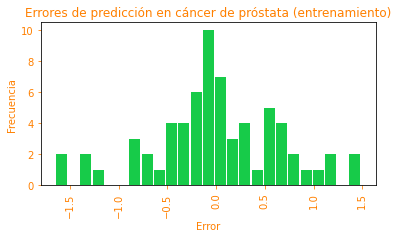

In [979]:
dibuja_hist(df,colour='#17cb49',name='hist9.png',Xlabel="Error",Ylabel="Frecuencia",title="Errores de predicción en cáncer de próstata (entrenamiento)")

Ahora, utilizamos el modelo obtenido con los datos de entrenamiento para predecir los datos de prueba. Además,  calculamos los errores entre la predicción `y_pred2` y los datos de prueba $Yt$. Los errores de la predicción con datos de prueba son representados por un histograma.

In [980]:
y_pred2 = pronostica(results.params,X_test)
error2 = y_test - y_pred2
err_regress_t = mean_absolute_error(y_test,y_pred2)
df = pd.DataFrame(error2,y_test)

<Figure size 432x288 with 0 Axes>

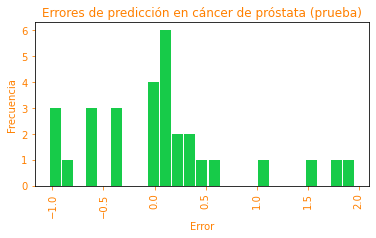

In [981]:
dibuja_hist(df,colour='#17cb49',name='hist10.png',Xlabel="Error",Ylabel="Frecuencia",title="Errores de predicción en cáncer de próstata (prueba)")

Ahora, calculamos el **error absoluto medio (MAE)** de los datos de entrenamiento así como de los datos de prueba en la predicción de cancer de próstata.

In [982]:
print("MAE del modelo de regresión con datos de entrenamiento:", err_regress)
print("MAE del modelo de regresión con datos de prueba:" , err_regress_t) 

MAE del modelo de regresión con datos de entrenamiento: 0.49861362344949917
MAE del modelo de regresión con datos de prueba: 0.5332335474812145


Finalmente calculamos los intervalos de confianza de los coeficientes del modelo de regresión así como los p-values:

In [983]:
print(results.conf_int(alpha=0.05, cols=None))
print(results.pvalues)

[[ 2.27815644  2.62653373]
 [ 0.44917503  0.983639  ]
 [ 0.07968993  0.50559488]
 [-0.34696416  0.0618649 ]
 [ 0.00558193  0.41843328]
 [ 0.05862448  0.56061459]
 [-0.59887957  0.02086833]
 [-0.30631449  0.26448745]
 [-0.04211288  0.59680478]]
[1.53766865e-35 1.46941496e-06 7.91789491e-03 1.68062590e-01
 4.43078420e-02 1.65053869e-02 6.69708471e-02 8.83892314e-01
 8.75462787e-02]


### Regression del mejor subconjunto aplicado 

a la predicción de cáncer de próstata aplicaremos la técnica de regresión del mejor subconjunto **(Best Subset Regression)** a los datos de entrenamiento de cáncer de próstata. La aplicación de este método sugiere utilizar las variables (features) [1, 2, 3, 4, 5, 6, 8]; es decir: ['lweight','age','lbph','svi','lcp','gleason','pgg45'] para lograr un mínimo error entre todas las combinaciones de las variables. Otras técnicas de reducción de dimensiones de modelos de regresión puede encontrarse en: [A Comparison of Shrinkage and Selection Methods for Linear Regression](https://towardsdatascience.com/a-comparison-of-shrinkage-and-selection-methods-for-linear-regression-ee4dd3a71f16).

In [984]:
## Loop over all possible numbers of features to be included
results = pd.DataFrame(columns=['num_features', 'features', 'MAE'])
for k in range(1, X_train.shape[1] + 1):
    # Loop over all possible subsets of size k
    for subset in itertools.combinations(range(X_train.shape[1]), k):
        subset = list(subset)        
        linreg_model = LinearRegression().fit(X_train[:, subset], y_train)
        linreg_prediction = linreg_model.predict(X_train[:, subset])
        linreg_mae = np.mean(np.abs(y_train - linreg_prediction))
        #print(subset," ",linreg_mae)
        results = results.append(pd.DataFrame([{'num_features': k,
                                                'features': subset,
                                                'MAE': linreg_mae}]))
print(results.sort_values('MAE'))
err_regress_subset = results.sort_values('MAE')['MAE'].head(1)

   num_features                     features       MAE
0             7        [1, 2, 3, 4, 5, 6, 8]  0.497997
0             8     [0, 1, 2, 3, 4, 5, 6, 8]  0.497997
0             9  [0, 1, 2, 3, 4, 5, 6, 7, 8]  0.498614
0             8     [1, 2, 3, 4, 5, 6, 7, 8]  0.498614
0             7        [1, 2, 3, 4, 5, 6, 7]  0.504766
..          ...                          ...       ...
0             2                       [0, 7]  0.904978
0             1                          [7]  0.904978
0             2                       [0, 3]  0.905767
0             1                          [3]  0.905767
0             1                          [0]  0.961085

[511 rows x 3 columns]


## Regresión lineal en predicción de demanda eléctrica

A continuación haremos la comparación de resultados de regresión para datos de demanda eléctrica. La variable independiente $X$ serán los datos de demanda del día anterior, y los datos independiente $Y$ serán los datos de días con una mayor correlación. En esta sección, aplicaremos algunas de las técnicas de regresión que aplican reducción de dimensiones y pueden encontrarse en: [A Comparison of Shrinkage and Selection Methods for Linear Regression](https://towardsdatascience.com/a-comparison-of-shrinkage-and-selection-methods-for-linear-regression-ee4dd3a71f16).

Los datos usados en esta sección están disponibles en [demanda.csv](https://drive.google.com/file/d/1KpY2p4bfVEwGRh5tJjMx9QpH6SEwrUwH/view?usp=sharing)

In [985]:
df = pd.read_csv('demanda.csv')

In [986]:
## Procesamos datos de entrenamiento 
df1 = df.loc[df.iloc[:,19].isin(['T'])] ## 'T' = training set
df2 = df1['Y']  
df1 = df1[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']] ## Regresores

Ahora, cargamos los datos de prueba en los arreglos `X_train` y `y_train`:

In [987]:
## Procesamos datos de prueba 
dft = df.loc[df.iloc[:,19].isin(['F'])] ## 'F' = test set
dft2 = dft['Y']
dft1 = dft[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']] ## Regresores

Estandarizamos los datos de los regresores `X_train` y `X_test` restando la media y dividiendo entre la varianza.

In [988]:
df1.std(numeric_only = True) 
df1.mean(numeric_only = True)
df1 = df1 - df1.mean(numeric_only = True)
df1 = df1 / df1.std(numeric_only = True) 
X_train = df1.to_numpy()   ## Predictors
X_train = sm.add_constant(X_train)
y_train = df2.to_numpy()   ## Outcome

In [989]:
dft1.std(numeric_only = True) 
dft1.mean(numeric_only = True)
dft1 = dft1 - dft1.mean(numeric_only = True)
dft1 = dft1 / dft1.std(numeric_only = True) 
X_test = dft1.to_numpy()   ## Predictors
X_test = sm.add_constant(X_test)
y_test = dft2.to_numpy()   ## Outcome

A continuación, obtenemos un modelo de predicción de los datos de entrenamiento usando regresión lineal.

In [990]:
model   = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary()) 
#print(results.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     538.6
Date:                Tue, 25 Jan 2022   Prob (F-statistic):          4.18e-175
Time:                        08:08:01   Log-Likelihood:                -1793.1
No. Observations:                 288   AIC:                             3608.
Df Residuals:                     277   BIC:                             3649.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8705.1904      7.354   1183.811      0.0

Ahora, calculamos los errores entre la predicción `y_pred` y los datos de entrenamiento `y_train`. Los errores son representados por un histograma.

In [991]:
y_pred     = pronostica(results.params,X_train)
error      = y_train - y_pred
err_train  = mean_absolute_error(y_pred,y_train)
bias_train = bias.bias(y_pred,y_train, axis=0)
df         = pd.DataFrame(error,y_train)

<Figure size 432x288 with 0 Axes>

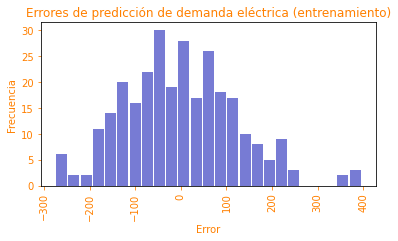

In [992]:
dibuja_hist(df,colour='#777bd4',name='hist11.png',Xlabel="Error",Ylabel="Frecuencia",title="Errores de predicción de demanda eléctrica (entrenamiento)")

Ahora, utilizamos el modelo obtenido con los datos de entrenamiento para predecir los datos de prueba. Además,  calculamos los errores entre la predicción `y_pred2` y los datos de prueba $Yt$. Los errores de la predicción con datos de prueba son representados por un histograma.

In [993]:
y_pred2   = pronostica(results.params,X_test) #print(y_pred2)
error2    = y_test - y_pred2
err_test  = mean_absolute_error(y_test,y_pred2)
bias_test = bias.bias(y_test,y_pred2,axis=0)
df        = pd.DataFrame(error2,y_test)

<Figure size 432x288 with 0 Axes>

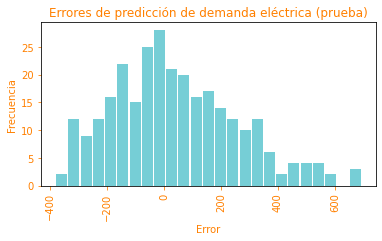

In [994]:
dibuja_hist(df,colour='#76ced6',name='hist12.png',Xlabel="Error",Ylabel="Frecuencia",title="Errores de predicción de demanda eléctrica (prueba)")

Ahora, comparamos el **error absoluto medio (MAE)** y **bias** de los datos de entrenamiento así como de los datos de prueba en la predicción de cancer de próstata.

In [995]:
print("MAE y bias del modelo de regresión con datos de entrenamiento:", err_train, "," , bias_train)
print("MAE y bias del modelo de regresión con datos de prueba:" , err_test, "," , bias_test) 

MAE y bias del modelo de regresión con datos de entrenamiento: 97.14455057297401 , 7.787548383930698e-12
MAE y bias del modelo de regresión con datos de prueba: 176.16762326247263 , 40.949549670130864


### Regresión de mejor subconjunto aplicado a la predicción de pronóstico de demanda eléctrica
Aplicaremos la técnica de regression del mejor subconjunto **(Best Subset Regression)** a los datos de entrenamiento de pronóstico de demanda.
Otras técnicas de reducción de dimensión y compactación de modelos de regresión puede encontrarse en: [A Comparison of Shrinkage and Selection Methods for Linear Regression](https://towardsdatascience.com/a-comparison-of-shrinkage-and-selection-methods-for-linear-regression-ee4dd3a71f16). La aplicación de este método sugiere utilizar las variables (features) (0, 1, 2, 3, 5, 7, 9]; es decir [X1, X2, X3, X6, X8, X10] para lograr un mínimo error entre todas las combinaciones de las variables.

In [996]:
## Loop over all possible numbers of features to be included
results = pd.DataFrame(columns=['num_features', 'features', 'MAE'])
for k in range(1, X_train.shape[1] + 1):
    # Loop over all possible subsets of size k
    for subset in itertools.combinations(range(X_train.shape[1]), k):
        subset = list(subset)        
        linreg_model = LinearRegression().fit(X_train[:, subset], y_train)
        linreg_prediction = linreg_model.predict(X_train[:, subset])
        linreg_mae = np.mean(np.abs(y_train - linreg_prediction))
        results = results.append(pd.DataFrame([{'num_features': k,
                                                'features': subset,
                                                'MAE': linreg_mae}]))
print(results.sort_values('MAE'))
subset_best = list(results.sort_values('MAE')['features'].head(1)[0]) ## Seleccionamos el mejor subconjunto con menor MAE

   num_features                   features         MAE
0             6        [1, 2, 3, 7, 8, 10]   95.651466
0             7     [0, 1, 2, 3, 7, 8, 10]   95.651466
0             8  [0, 1, 2, 3, 6, 7, 8, 10]   95.724433
0             7     [1, 2, 3, 6, 7, 8, 10]   95.724433
0             8  [0, 1, 2, 3, 7, 8, 9, 10]   95.737479
..          ...                        ...         ...
0             1                       [10]  145.218521
0             2                    [0, 10]  145.218521
0             2                     [0, 5]  151.493611
0             1                        [5]  151.493611
0             1                        [0]  463.242794

[2047 rows x 3 columns]


In [997]:
modelsub = LinearRegression().fit(X_train[:, subset_best], y_train)
subset_prediction = modelsub.predict(X_test[:, subset_best])
err_test_subset  = np.mean(np.abs(y_test - subset_prediction))
bias_test_subset = bias.bias(y_test,subset_prediction,axis=0)
print("MAE y bias del modelo de regresión con datos de prueba (subset):" , err_test_subset, "," , bias_test_subset) 

MAE y bias del modelo de regresión con datos de prueba (subset): 173.52741890377197 , 40.9495496701377


### Regresión Ridge aplicada a la predicción de pronóstico de demanda eléctrica
Aplicaremos la técnica de regresión ridge **(Ridge Regression)** a los datos de entrenamiento de pronóstico de demanda.

In [998]:
ridge_cv = RidgeCV(normalize=True, alphas=np.logspace(-10, 1, 400))
ridge_model = ridge_cv.fit(X_train, y_train)
ridge_prediction = ridge_model.predict(X_test)
err_test_ridge = np.mean(np.abs(y_test - ridge_prediction))  ## MAE
bias_test_ridge = bias.bias(y_test,ridge_prediction,axis=0)
#print(ridge_model.intercept_)
#print(ridge_model.coef_)
print("MAE y bias del modelo de regresión con datos de prueba (ridge):" , err_test_ridge, "," , bias_test_ridge)

MAE y bias del modelo de regresión con datos de prueba (ridge): 172.5657356532211 , 40.9495496701379


### Regresión Lasso aplicada a la predicción de pronóstico de demanda eléctrica
Aplicaremos la técnica de regresión lasso **(lasso regression)** a los datos de entrenamiento de pronóstico de demanda.

In [999]:
lasso_cv         = LassoCV(normalize=True, alphas=np.logspace(-10, 1, 400))
lasso_model      = lasso_cv.fit(X_train, y_train)
lasso_prediction = lasso_model.predict(X_test)
err_test_lasso   = np.mean(np.abs(y_test - lasso_prediction)) ## MAE
bias_test_lasso  = bias.bias(y_test,lasso_prediction,axis=0)
#print(lasso_model.intercept_)
#print(lasso_model.coef_)
print("MAE y bias del modelo de regresión con datos de prueba (lasso):" , err_test_lasso, "," , bias_test_lasso)

MAE y bias del modelo de regresión con datos de prueba (lasso): 169.12264945942172 , 40.94954967013699


### Regresión de componentes principales aplicado a la predicción de pronóstico de demanda eléctrica
Aplicaremos la técnica de regresión de componentes principales **(Principal Components Regression)** a los datos de entrenamiento de pronóstico de demanda.

In [1000]:
regression_model = LinearRegression(normalize=True)
pca_model = PCA()
pipe = Pipeline(steps=[('pca', pca_model), ('least_squares', regression_model)])
param_grid = {'pca__n_components': range(1, 9)}
search = GridSearchCV(pipe, param_grid)
pcr_model = search.fit(X_train, y_train)
pcr_prediction = pcr_model.predict(X_test)
err_test_pcr = np.mean(np.abs(y_test - pcr_prediction))  ## MAE
bias_test_pcr  = bias.bias(y_test,lasso_prediction,axis=0)
n_comp = list(pcr_model.best_params_.values())[0]

print("MAE y bias del modelo de regresión con datos de prueba (pcr):" , err_test_pcr, "," , bias_test_pcr)

MAE y bias del modelo de regresión con datos de prueba (pcr): 164.41507897155782 , 40.94954967013699


### Regresión por mínimos cuadrados parciales aplicado a la predicción de pronóstico de demanda eléctrica
Aplicaremos la técnica de regresión de componentes principales **(Partial Least Squares)** a los datos de entrenamiento de pronóstico de demanda.

In [1001]:
pls_model_setup = PLSRegression(scale=True)
param_grid = {'n_components': range(1, 9)}
search = GridSearchCV(pls_model_setup, param_grid)
pls_model = search.fit(X_train, y_train)
pls_prediction = pls_model.predict(X_test)
err_test_pls = np.mean(np.abs(y_test - pls_prediction))  ## MAE
bias_test_pls = bias.bias(y_test,lasso_prediction,axis=0)
#print(pls_model.best_estimator_.coef_)
print("MAE y bias del modelo de regresión con datos de prueba (pls):" , err_test_pls, "," , bias_test_pls)

MAE y bias del modelo de regresión con datos de prueba (pls): 545.5517510409218 , 40.94954967013699


Por último graficamos los resultados de predicción de las diferentes técnicas de regresión y los resultados de prueba Y.

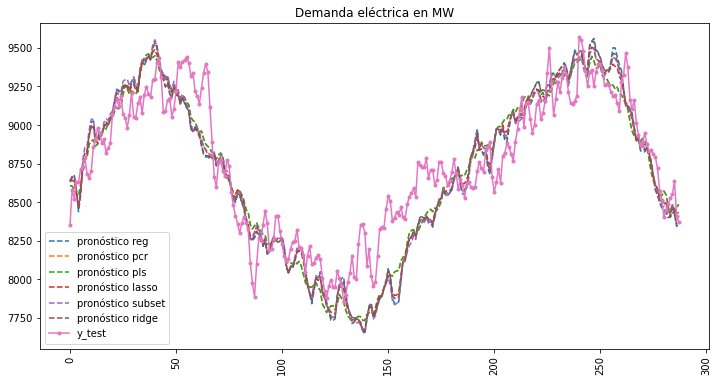

In [1002]:
dfreg=pd.DataFrame(y_pred2)
dfpcr=pd.DataFrame(pcr_prediction)
dfpls=pd.DataFrame(pls_prediction)
dflas=pd.DataFrame(lasso_prediction)
dfsub=pd.DataFrame(subset_prediction)
dfrid=pd.DataFrame(ridge_prediction)
dftest=pd.DataFrame(y_test)
plt.figure(figsize=(12,6))
plt.plot(dfreg, '--', label='pronóstico reg')
plt.plot(dfpcr, '--', label='pronóstico pcr')
plt.plot(dfpls, '--', label='pronóstico pls')
plt.plot(dflas, '--', label='pronóstico lasso')
plt.plot(dfsub, '--', label='pronóstico subset')
plt.plot(dfrid, '--', label='pronóstico ridge')
plt.plot(dftest,'.-', label='y_test')
plt.xticks(rotation=90)
plt.legend()
plt.title('Demanda eléctrica en MW')
plt.savefig('pronodemanda.png', transparent=True)
plt.show()
